# Apple Google NLP

# Overview

This project analyzes [tweets talking about SXSW products](https://data.world/crowdflower/brands-and-product-emotions). I first ran NLP on the tweet data to break down most common words for positive and negative tweets. I then identified what product and emotion a tweet was talking about. I next converted categorical columns to numeric columns and used those columns to identify recall scores for positive and negative tweets using our algorithm. I finished with scoring the products by the ratio of positive to all tweets with emotion.

# Business Problem

I work for a data company where we are hired by different companies who display their products at different conventions.

I was instructed to decode the responses of products displayed at South by South West (SXSW), see which words on twitter signify positive or negative sentiment, and seeing which product was seen to be the most favorable at SXSW.

# Data Source

[Tweet data](https://data.world/crowdflower/brands-and-product-emotions) was sourced from a past SXSW (before 2014). Tweets were found if they included SXSW and an Apple or Google product. Contributors manually evaluated tweets about different brands and products. They were asked to decide if the tweet expressed positive, negative or no emotion. If some emotion was expressed, they were asked to say which brand and product.

# Results

I determined different words that were used to identify tweets with positive and negative emotion. The algorithm had a better recall score of predicting positive tweets than negative ones. I also found that tweets talking about Android Apps had the best positive to negative ratio of the products.

# Importing

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

import nltk
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Read in and Filtering

In [2]:
#read in tweets from data, about 9000 rows and three columns
df = pd.read_csv("data/twitter_data.csv", encoding="unicode_escape")
#dropped one tweet that had a NA value (row 6)
df = df.loc[df["tweet_text"].notna()]

# Text Preprocessing

In [3]:
def preprocess_text(tweet):
    #tweets to lowercase
    tweet = tweet.lower()
    #tokenize, word by word into a list, only 3 letter words and above
    tweet = RegexpTokenizer(r"(?u)\w{3,}").tokenize(tweet)
    #taken out words that have no meaning like "and"
    tweet = [word for word in tweet if word not in stopwords.words("english")]
    #stemming, reduces a word to its word stem
    tweet = [PorterStemmer().stem(word) for word in tweet]
    return tweet

df["preprocessed_text"] = [preprocess_text(tweet) for tweet in df["tweet_text"]]

# Identifying Values

In [4]:
#identifying the company in the tweet
def company(tweet):
    #apple products
    if "appl" in tweet or "iphon" in tweet or "ipad" in tweet:
        return "Apple"
    #google products
    elif "googl" in tweet or "android" in tweet:
        return "Google"

df["predict_directed"] = [company(tweet) for tweet in df["preprocessed_text"]]

In [5]:
#Identifying the product in the tweet
def directed_at(tweet):
    if "app" in tweet[3]:
        if tweet[4] == "Apple":
            return "Ipad or Iphone App"
        else:
            return "Android App"
    elif "ipad" in tweet[3]:
        return "Ipad"
    elif "iphon" in tweet[3]:
        return "Iphone"
    elif "android" in tweet[3]:
        return "Android"
    else:
        return tweet[4]

df["predict_directed"] = [directed_at(tweet) for tweet in df.values]

In [6]:
#dictionary to track popular words in positive tweets
positive_wordcount = {}
for row in df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Positive emotion"]["preprocessed_text"]:
    for word in row:
        if word in positive_wordcount:
            positive_wordcount[word] += 1
        else:
            positive_wordcount[word] = 1

for key in list(positive_wordcount.keys()):
    #Word must show up atleast 50 times or it isnt counted as a common word
    if positive_wordcount[key] < 50:
        del positive_wordcount[key]

#dictionary to track popular words in negative tweets
negative_wordcount = {}
for row in df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Negative emotion"]["preprocessed_text"]:
    for word in row:
        if word in negative_wordcount:
            negative_wordcount[word] += 1
        else:
            negative_wordcount[word] = 1

for key in list(negative_wordcount.keys()):
    #Word must show up atleast 10 times or it isnt counted as a common word
    #value is less than the positive value because there are less negative tweets
    if negative_wordcount[key] < 10:
        del negative_wordcount[key]


In [7]:
#using words in tweets to predict a negative or positive emotion
def emotion(tweet):
    if ("great" in tweet or "awesom" in tweet or "like" in tweet or "appreci" in tweet or "good" in tweet
            or "beauti" in tweet or "smart" in tweet or "excit" in tweet or "wait" in tweet or "best" in tweet
            or "love" in tweet or "nice" in tweet or "must" in tweet or "enjoy" in tweet or "fun" in tweet
            or "rock" in tweet or "cool" in tweet):
        return "Positive emotion"
    elif ("dead" in tweet or "insan" in tweet or "headach" in tweet or "long" in tweet or "fail" in tweet or "hate" in tweet
            or "suck" in tweet or "fascist" in tweet or "fade" in tweet or "crashi" in tweet):
        return "Negative emotion"
    else:
        return "No emotion"

df["predict_emotion"] = [emotion(tweet) for tweet in df["preprocessed_text"]]

# Convert Categorical Columns to Numeric Columns

In [8]:
#if tweet is positive, its 1, else its a 0
def positive_normalize(emotion):
    if emotion == "Positive emotion":
        return 1
    else:
        return 0
#if tweet is negative, its 1, else its a 0
def negative_normalize(emotion):
    if emotion == "Negative emotion":
        return 1
    else:
        return 0
#actual values from contributors
df["positive"] = [positive_normalize(emotion) for emotion in df["is_there_an_emotion_directed_at_a_brand_or_product"]]
df["negative"] = [negative_normalize(emotion) for emotion in df["is_there_an_emotion_directed_at_a_brand_or_product"]]
#predicted values
df["predict_positive"] = [positive_normalize(emotion) for emotion in df["predict_emotion"]]
df["predict_negative"] = [negative_normalize(emotion) for emotion in df["predict_emotion"]]

# Sucess of Identifying Emotion

In [9]:
recall_score(df["positive"], df["predict_positive"])

0.3247145735392881

32% of Positive tweets are identified. Good result as we only had about 2500 tweets to look into to identify positivity.

In [10]:
recall_score(df["negative"], df["predict_negative"])

0.15964912280701754

16% of Negative tweets are identified. Understandable that recall score was lower with less tweets to evaluate and less words to add to search for negativity.

# Visuals

## Amount of Tweets per Emotion

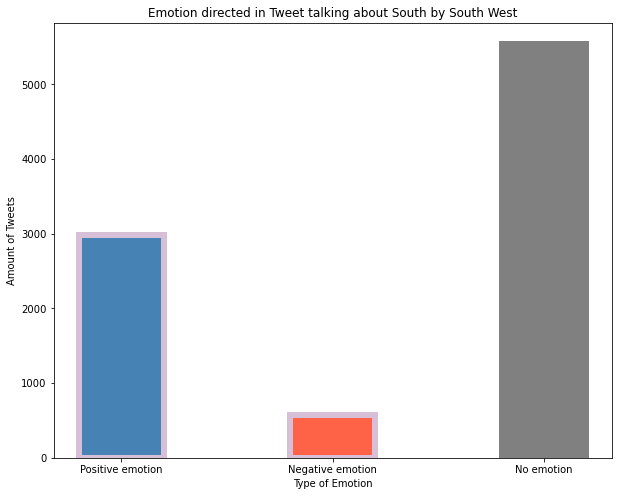

In [11]:
#dictionary to count how many tweets were identified as each emotion
emotion_counts = {"Positive emotion": 0, "Negative emotion": 0, "No emotion": 0}
for tweet in df["is_there_an_emotion_directed_at_a_brand_or_product"]:
    if tweet == "No emotion toward brand or product" or tweet == "I can't tell":
        emotion_counts["No emotion"] += 1
    else:
        emotion_counts[tweet] += 1

fig = plt.figure(figsize = (10, 8))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color = ["steelblue", "tomato", "grey"],
        edgecolor = ["thistle", "thistle", "grey"], linewidth = 6, width = 0.4)
plt.title("Emotion directed in Tweet talking about South by South West")
plt.xlabel("Type of Emotion")
plt.ylabel("Amount of Tweets")
plt.show()

We see that most tweets were seen to have no emotion or the evaluater couldnt identify the emotion. We will remove no emotion from our graph as it isn't important to our business problem as we are only looking to see how to identify positive and negative tweets

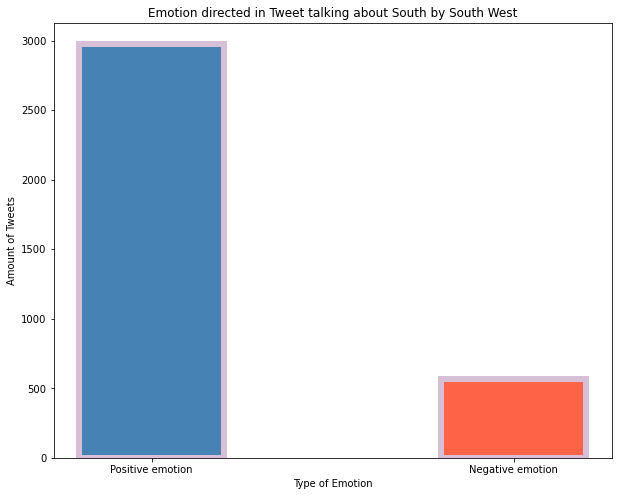

In [12]:
del emotion_counts['No emotion']

fig = plt.figure(figsize = (10, 8))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color = ["steelblue", "tomato"],
        edgecolor = "thistle", linewidth = 6, width = 0.4)
plt.title("Emotion directed in Tweet talking about South by South West")
plt.xlabel("Type of Emotion")
plt.ylabel("Amount of Tweets")
plt.show()

We see that there are far more positive tweets than negative tweets. This explains why it is easier to identify words that invoke positive sentiment than negative ones. Even with the amount of positive tweets, we still are only able to get a recall score of 32%

## Finding Product with highest positivity

In [13]:
#remove tweets with no emotion as we are only worried about the difference between positive and negative perception of products
df_with_emotion = df.loc[df["predict_emotion"] != "No emotion"]

#seperate by products
google = df_with_emotion.loc[df["predict_directed"] == "Google"]
ipad = df_with_emotion.loc[df["predict_directed"] == "Ipad"]
apple = df_with_emotion.loc[df["predict_directed"] == "Apple"]
iphone = df_with_emotion.loc[df["predict_directed"] == "Iphone"]
apple_app = df_with_emotion.loc[df["predict_directed"] == "Ipad or Iphone App"]
android = df_with_emotion.loc[df["predict_directed"] == "Android"]
android_app = df_with_emotion.loc[df["predict_directed"] == "Android App"]

#divide positive reception by total number of tweets by product then multiplied by 100 to get a percent
positive_products = pd.DataFrame(
   dict(
      products=["Google", "Ipad", "Apple", "Iphone", "Ipad or Iphone App", "Android", "Android App"],
      positive_rate=[
          100 * len(google.loc[google["predict_positive"] == 1]) / len(google), 
          100 * len(ipad.loc[ipad["predict_positive"] == 1]) / len(ipad), 
          100 * len(apple.loc[apple["predict_positive"] == 1]) / len(apple), 
          100 * len(iphone.loc[iphone["predict_positive"] == 1]) / len(iphone), 
          100 * len(apple_app.loc[apple_app["predict_positive"] == 1]) / len(apple_app),
          100 * len(android.loc[android["predict_positive"] == 1]) / len(android),
          100 * len(android_app.loc[android_app["predict_positive"] == 1]) / len(android_app)]
   )).sort_values("positive_rate", ascending=False)

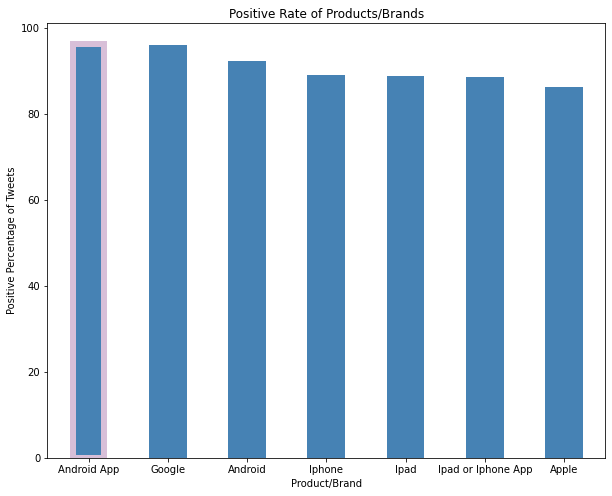

In [14]:
fig = plt.figure(figsize = (10, 8))
plt.bar(positive_products["products"], positive_products["positive_rate"], color = ["steelblue"],
        edgecolor = ["thistle", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue"], 
        linewidth = 6, width = 0.4)
plt.title("Positive Rate of Products/Brands")
plt.xlabel("Product/Brand")
plt.ylabel("Positive Percentage of Tweets")
plt.show()

From our data exploration, we can find that Android Apps are seen the most favorable from any product from South by South West, although every product seems to have quite alot of positive sentiment to them. This can be explained by the unequal class divide of emotion between tweets. With about 1700 positive tweets and 200 negative tweets. A solution would seeing if this is constant to other social media besides twitter.

## Positive Word Cloud

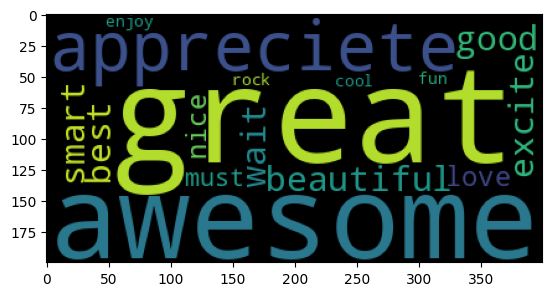

In [6]:
wc = WordCloud().generate("great awesome like appreciete good beautiful smart excite wait best love nice must enjoy fun rock cool")
plt.imshow(wc)

Includes words used to identify positive tweets

## Negative Word Cloud

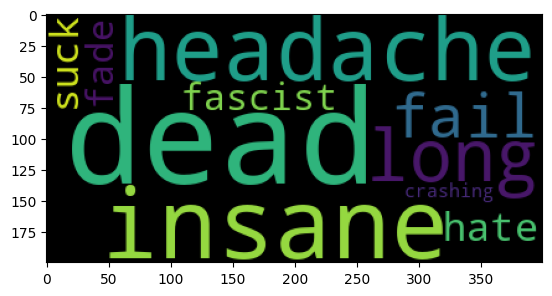

In [10]:
wc = WordCloud().generate("dead insane headache long fail hate suck fascist fade crashing")
plt.imshow(wc)

Includes words used to identify negative tweets

# File Write Out

In [15]:
#df.to_csv('data/final_data.csv')

# Conclusions

Positive Words: great awesome like appreciete good beautiful smart excite wait best love nice must enjoy fun rock cool
Negative Words: dead insane headache long fail hate suck fascist fade crashing

32% Recall for Positive Tweets
16% Recall for Negative Tweets

Android App Tweets were seen to have the best ratio of positive to all tweets with emotion

# Further Results

See what business practices corresponds with different emotion tweets. This will allow businesses to improve or keep with the same practices that allowed them to get positive sentiment. 

Look at more than one social media and other conventions/events. See if our words are correct across the board or if there are different words based on different social media apps. It also would be beneficial to see if there are any other negative words we could add to our list with more data

Look into no emotion tweets and research how to convert them to positive ones. It is easier for companies to convert neutral rather than negative tweets and it would be beneficial for companies to understand how to direct their initiatives in further conventions.

# APPENDIX

In [15]:
#checks how many tweets are retweets (a tweet was reposted by another user).
#There were 2677 retweets
len([row for row in df["tweet_text"] if "RT" in row])

#I think this tweet is interesting as its marked as positive but feels like it could be either
print(df['tweet_text'][9088])
print(df['is_there_an_emotion_directed_at_a_brand_or_product'][9088])
#or like this tweet where its marked as positive but its just remarking on the weather
print(df["tweet_text"][40])
print(df['is_there_an_emotion_directed_at_a_brand_or_product'][40])
#just points out that since this data is evaluated manually by people, some of the data could be classified
#with the wrong emotion, should have an emotion, or shouldn't have an emotion

Ipad everywhere. #SXSW {link}
Positive emotion
@mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2
Positive emotion


In [16]:
#CountVectorizer that ended up not being as useful. Ended up counting words by a for loop
corpus = []
for row in df["tweet_text"]:
    corpus += [row + ","]

vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=stopwords.words("english"))
X = vec.fit_transform(corpus)
df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,abilities,...,zms,zomb,zombie,zombies,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#neutral word count was taken out because the business problem didn't require looking at neutral emotion also.
#It served some use in being able to check positive/negative words that also had some neutral sentiment
neutral_wordcount = {}
for row in (df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]
            ["preprocessed_text"]):
    for word in row:
        if word in neutral_wordcount:
            neutral_wordcount[word] += 1
        else:
            neutral_wordcount[word] = 1
for row in (df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]["preprocessed_text"]):
    for word in row:
        if word in neutral_wordcount:
            neutral_wordcount[word] += 1
        else:
            neutral_wordcount[word] = 1


for key in list(neutral_wordcount.keys()):
    if neutral_wordcount[key] < 50:
        del neutral_wordcount[key]

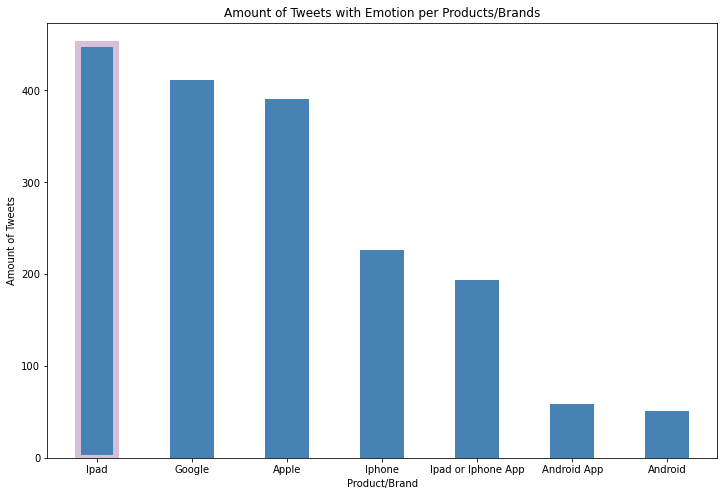

In [22]:
#tracks amount of tweets per brand/product if it has emotion
fig = plt.figure(figsize = (12, 8))
plt.bar(["Ipad", "Google", "Apple", "Iphone", "Ipad or Iphone App", "Android App", "Android"], 
        [len(ipad), len(google), len(apple), len(iphone), len(apple_app), len(android_app), len(android)], color = ["steelblue"],
        edgecolor = ["thistle", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue", "steelblue"], 
        linewidth = 6, width = 0.4)
plt.title("Amount of Tweets with Emotion per Products/Brands")
plt.xlabel("Product/Brand")
plt.ylabel("Amount of Tweets")
plt.show()